In [1]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [2]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics

In [15]:
from sklearn.model_selection import train_test_split
# Load the data
train = pd.read_csv("/content/train.csv")
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)
# Normalize the data
X_train = X_train / 255.0
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
# create an anomaly hold out group and then only train with the remaining digits
anom_mask = (Y_train==9)
anomaly_test = X_train[anom_mask]
X_train = X_train[~anom_mask]
Y_train = Y_train[~anom_mask]
# make a test set the same size as the anomaly set
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=anomaly_test.shape[0], random_state=42)
print('Training Images', X_train.shape, 'Testing Images', X_test.shape, 'Anomaly Images', anomaly_test.shape)

Training Images (33624, 28, 28, 1) Testing Images (4188, 28, 28, 1) Anomaly Images (4188, 28, 28, 1)


In [38]:
Y_train.head()

27249    4
29694    3
9152     6
25202    1
11103    0
Name: label, dtype: int64

In [16]:
batch_size = 256
original_shape = X_train.shape[1:]
original_dim = np.prod(original_shape)
latent_dim = 4
intermediate_dim = 128
final_dim = 64
epochs = 50
epsilon_std = 1.0

# Building VAE Model

In [17]:
in_layer = Input(shape=original_shape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(original_shape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_img)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 784)                  0         ['input_3[0][0]']             
                                                                                                  
 dense_14 (Dense)            (None, 128)                  100480    ['flatten_2[0][0]']           
                                                                                                  
 dense_15 (Dense)            (None, 64)                   8256      ['dense_14[0][0]']            
                                                                                            

In [18]:
vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(anomaly_test, None))

Epoch 1/50
132/132 [==============================] - 3s 17ms/step - loss: 223.2699 - val_loss: 186.2462
Epoch 2/50
132/132 [==============================] - 2s 16ms/step - loss: 176.1651 - val_loss: 163.0260
Epoch 3/50
132/132 [==============================] - 2s 15ms/step - loss: 163.8072 - val_loss: 152.8369
Epoch 4/50
132/132 [==============================] - 2s 16ms/step - loss: 157.5383 - val_loss: 147.6242
Epoch 5/50
132/132 [==============================] - 3s 21ms/step - loss: 153.6250 - val_loss: 144.1247
Epoch 6/50
132/132 [==============================] - 3s 23ms/step - loss: 150.6969 - val_loss: 142.4275
Epoch 7/50
132/132 [==============================] - 2s 16ms/step - loss: 148.2104 - val_loss: 143.0664
Epoch 8/50
132/132 [==============================] - 2s 15ms/step - loss: 146.1586 - val_loss: 142.1776
Epoch 9/50
132/132 [==============================] - 2s 16ms/step - loss: 144.4003 - val_loss: 141.3417
Epoch 10/50
132/132 [==============================] - 

In [19]:
# Compute reconstruction error
def model_mse(x, vae, batch_size):
    return np.mean(np.square(x - vae.predict(x, batch_size=batch_size)), axis=(1,2,3))

In [20]:
train_mse = model_mse(X_train, vae, batch_size)
test_mse = model_mse(X_test, vae, batch_size)
anomaly_mse = model_mse(anomaly_test, vae, batch_size)

17/17 [==============================] - 0s 8ms/step


In [35]:
# Assuming train_mse, test_mse, and anomaly_mse are already calculated
vae_reconstruction_errors = np.concatenate([train_mse, test_mse, anomaly_mse])

In [25]:
anomaly_test.shape

(4188, 28, 28, 1)

In [26]:
X_train.shape

(33624, 28, 28, 1)

In [27]:
X_test.shape

(4188, 28, 28, 1)

In [28]:
# Flatten the data if it's not already flattened
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
anomaly_data_flat = anomaly_test.reshape(anomaly_test.shape[0], -1)

In [30]:
X_train_flat.shape, X_test_flat.shape, anomaly_data_flat.shape

((33624, 784), (4188, 784), (4188, 784))

In [31]:
# Combine the flattened data for clustering
combined_data_flat = np.concatenate([X_train_flat, X_test_flat, anomaly_data_flat])

In [32]:
combined_data_flat.shape

(42000, 784)

In [34]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np


# Train K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(combined_data_flat)
kmeans_distances = np.min(kmeans.transform(combined_data_flat), axis=1)

# Train GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(combined_data_flat)
gmm_log_likelihood = gmm.score_samples(combined_data_flat)

# Determine thresholds for anomaly detection
# K-means: Distance to nearest cluster center
kmeans_threshold = np.percentile(kmeans_distances, 95)

# GMM: Log-likelihood scores (lower scores are more anomalous)
gmm_threshold = np.percentile(gmm_log_likelihood, 5)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: ignored

In [36]:
# VAE: Reconstruction errors
vae_threshold = np.percentile(vae_reconstruction_errors, 95)

# Detect anomalies
anomalies_kmeans = kmeans_distances > kmeans_threshold
anomalies_gmm = gmm_log_likelihood < gmm_threshold
anomalies_vae = vae_reconstruction_errors > vae_threshold

In [37]:
# Assuming anomalies_kmeans, anomalies_gmm, anomalies_vae are arrays of boolean values indicating detected anomalies

# Convert boolean arrays to sets of indices for easier comparison
anomalies_kmeans_indices = set(np.where(anomalies_kmeans)[0])
anomalies_gmm_indices = set(np.where(anomalies_gmm)[0])
anomalies_vae_indices = set(np.where(anomalies_vae)[0])

# Count anomalies detected by each method
num_anomalies_kmeans = len(anomalies_kmeans_indices)
num_anomalies_gmm = len(anomalies_gmm_indices)
num_anomalies_vae = len(anomalies_vae_indices)

# Analyze the overlap
common_anomalies_all = anomalies_kmeans_indices & anomalies_gmm_indices & anomalies_vae_indices
common_anomalies_kmeans_gmm = anomalies_kmeans_indices & anomalies_gmm_indices
common_anomalies_kmeans_vae = anomalies_kmeans_indices & anomalies_vae_indices
common_anomalies_gmm_vae = anomalies_gmm_indices & anomalies_vae_indices

# Print the results
print("Number of anomalies detected by K-means:", num_anomalies_kmeans)
print("Number of anomalies detected by GMM:", num_anomalies_gmm)
print("Number of anomalies detected by VAE:", num_anomalies_vae)
print("Anomalies detected by all methods:", len(common_anomalies_all))
print("Anomalies detected by both K-means and GMM:", len(common_anomalies_kmeans_gmm))
print("Anomalies detected by both K-means and VAE:", len(common_anomalies_kmeans_vae))
print("Anomalies detected by both GMM and VAE:", len(common_anomalies_gmm_vae))


Number of anomalies detected by K-means: 2100
Number of anomalies detected by GMM: 2100
Number of anomalies detected by VAE: 2100
Anomalies detected by all methods: 148
Anomalies detected by both K-means and GMM: 433
Anomalies detected by both K-means and VAE: 491
Anomalies detected by both GMM and VAE: 368


In [39]:
# Assuming Y_test is the label array for your test dataset
true_labels = (Y_test == 9).astype(int)

In [40]:
true_labels.head()

3634     0
40010    0
21468    0
20496    0
1615     0
Name: label, dtype: int64

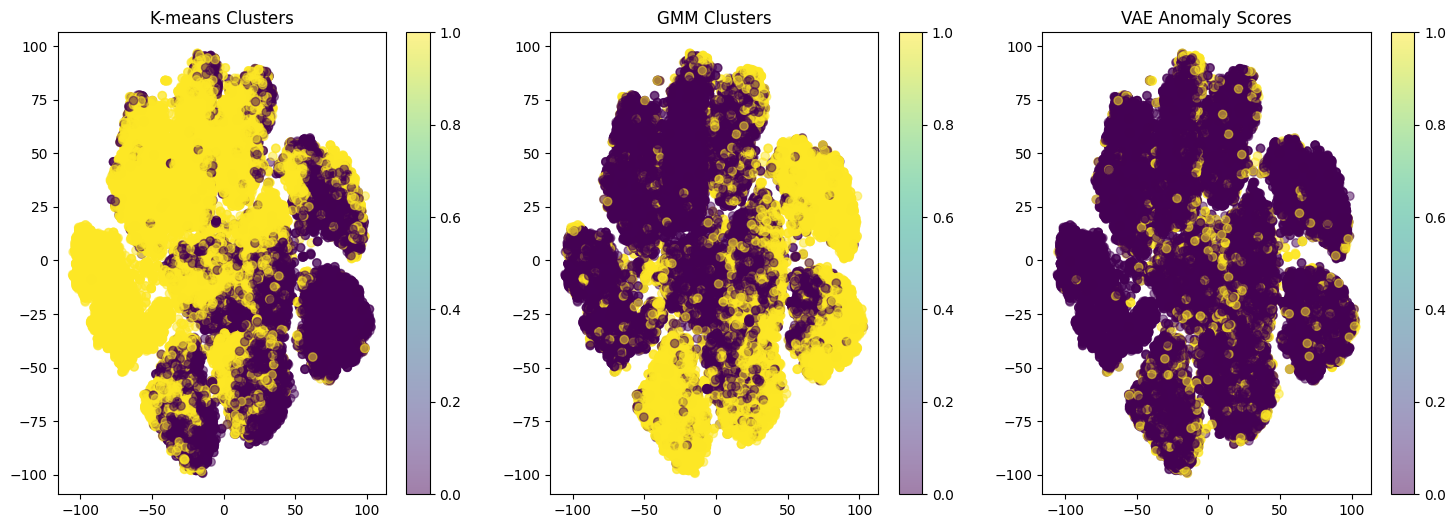

In [41]:
# ... [Your existing code above]

from sklearn.manifold import TSNE

# Apply t-SNE to the flattened combined data
tsne = TSNE(n_components=2, random_state=42)
combined_data_2d = tsne.fit_transform(combined_data_flat)

# Create labels for t-SNE plots
# Assuming labels_kmeans and labels_gmm are the clustering labels obtained from K-means and GMM
# For VAE, you can use binary labels based on the threshold or continuous scores
labels_kmeans = kmeans.predict(combined_data_flat)
labels_gmm = gmm.predict(combined_data_flat)
labels_vae = (vae_reconstruction_errors > vae_threshold).astype(int)

# Plotting the t-SNE results
plt.figure(figsize=(18, 6))

# K-means Clusters
plt.subplot(131)
plt.scatter(combined_data_2d[:, 0], combined_data_2d[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.5)
plt.title('K-means Clusters')
plt.colorbar()

# GMM Clusters
plt.subplot(132)
plt.scatter(combined_data_2d[:, 0], combined_data_2d[:, 1], c=labels_gmm, cmap='viridis', alpha=0.5)
plt.title('GMM Clusters')
plt.colorbar()

# VAE Anomaly Scores
plt.subplot(133)
plt.scatter(combined_data_2d[:, 0], combined_data_2d[:, 1], c=labels_vae, cmap='viridis', alpha=0.5)
plt.title('VAE Anomaly Scores')
plt.colorbar()

plt.show()


In [46]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Silhouette Score (for K-means and GMM)
silhouette_kmeans = silhouette_score(combined_data_flat, labels_kmeans)
silhouette_gmm = silhouette_score(combined_data_flat, labels_gmm)

# Davies-Bouldin Index and Calinski-Harabasz Index (for K-means and GMM)
dbi_kmeans = davies_bouldin_score(combined_data_flat, labels_kmeans)
dbi_gmm = davies_bouldin_score(combined_data_flat, labels_gmm)
chi_kmeans = calinski_harabasz_score(combined_data_flat, labels_kmeans)
chi_gmm = calinski_harabasz_score(combined_data_flat, labels_gmm)

# Reconstruction Error for VAE
# Assuming vae_reconstruction_errors is already calculated
mean_reconstruction_error_vae = np.mean(vae_reconstruction_errors)

# Printing the results
print("Silhouette Score - K-means:", silhouette_kmeans, "GMM:", silhouette_gmm)
print("Davies-Bouldin Index - K-means:", dbi_kmeans, "GMM:", dbi_gmm)
print("Calinski-Harabasz Index - K-means:", chi_kmeans, "GMM:",chi_gmm)
print("Mean Reconstruction Error - VAE:", mean_reconstruction_error_vae)

# Create true binary labels for anomalies (1 for digit '9', 0 for others)
true_labels_train = (Y_train == 9).astype(int)
true_labels_test = (Y_test == 9).astype(int)
true_labels_anomaly = np.ones(len(anomaly_test))  # All '9's in anomaly_test

# Combine the true labels
true_labels_combined = np.concatenate([true_labels_train, true_labels_test, true_labels_anomaly])

# Ensure the length of vae_reconstruction_errors matches true_labels_combined
assert len(vae_reconstruction_errors) == len(true_labels_combined), "Length mismatch"

# Now calculate precision, recall, F1-score, and ROC AUC
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision_vae, recall_vae, f1_vae, _ = precision_recall_fscore_support(true_labels_combined, vae_reconstruction_errors > vae_threshold, average='binary')
roc_auc_vae = roc_auc_score(true_labels_combined, vae_reconstruction_errors)

# Output the results
print("Precision - VAE:", precision_vae, "Recall - VAE:", recall_vae, "F1 Score - VAE:", f1_vae)
print("ROC AUC Score - VAE:", roc_auc_vae)


Silhouette Score - K-means: 0.08711525215145156 GMM: 0.051272947153207855
Davies-Bouldin Index - K-means: 3.7298610984180818 GMM: 4.99370804900446
Calinski-Harabasz Index - K-means: 2910.1857975914145 GMM: 1651.1049420221657
Mean Reconstruction Error - VAE: 0.0304995230664497
Precision - VAE: 0.1419047619047619 Recall - VAE: 0.07115568290353391 F1 Score - VAE: 0.09478371501272265
ROC AUC Score - VAE: 0.6439939979535815


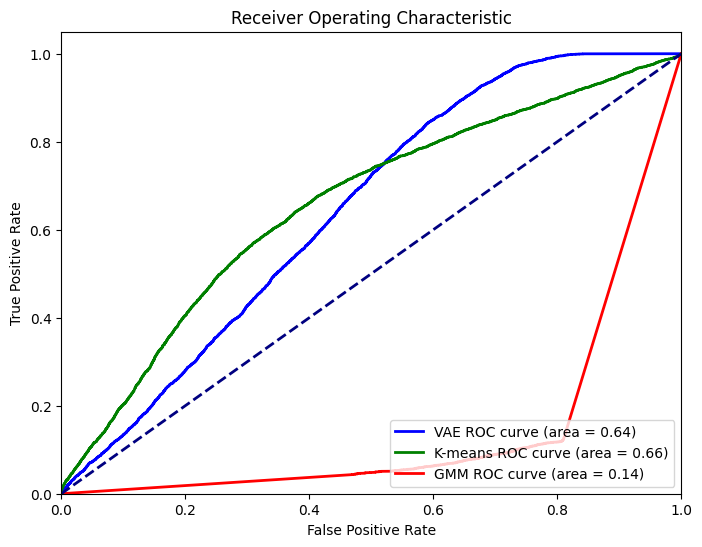

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC Curve for VAE
fpr_vae, tpr_vae, _ = roc_curve(true_labels_combined, vae_reconstruction_errors)
roc_auc_vae = auc(fpr_vae, tpr_vae)

# Calculate ROC Curve for K-means (using distance as the score)
fpr_kmeans, tpr_kmeans, _ = roc_curve(true_labels_combined, -kmeans_distances)
roc_auc_kmeans = auc(fpr_kmeans, tpr_kmeans)

# Calculate ROC Curve for GMM (using probability or log-likelihood as the score)
# You need to obtain these scores from your GMM model
# For example: gmm_scores = gmm.score_samples(X)
# Calculate the probabilities of belonging to each cluster
probabilities_gmm = gmm.predict_proba(combined_data_flat)

# If, for example, you consider the second cluster as the anomalous one
gmm_scores = probabilities_gmm[:, 1]  # Probabilities of being in the anomalous cluster

# Now recalculate the ROC Curve for GMM
fpr_gmm, tpr_gmm, _ = roc_curve(true_labels_combined, gmm_scores)
roc_auc_gmm = auc(fpr_gmm, tpr_gmm)

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_vae, tpr_vae, color='blue', lw=2, label='VAE ROC curve (area = %0.2f)' % roc_auc_vae)
plt.plot(fpr_kmeans, tpr_kmeans, color='green', lw=2, label='K-means ROC curve (area = %0.2f)' % roc_auc_kmeans)
plt.plot(fpr_gmm, tpr_gmm, color='red', lw=2, label='GMM ROC curve (area = %0.2f)' % roc_auc_gmm)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Number of components to try for GMM
n_components = np.arange(1, 10)  # Example range, can be changed based on your dataset
lowest_bic = np.infty
best_gmm = None
bic = []

# Try different numbers of components and covariance types
for n in n_components:
    for covar_type in ['spherical', 'diag', 'tied', 'full']:
        gmm = GaussianMixture(n_components=n, covariance_type=covar_type, random_state=42)
        gmm.fit(combined_data_flat)
        bic.append(gmm.bic(combined_data_flat))

        # Keep the model with the lowest BIC
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

# Fit the best GMM
best_gmm.fit(combined_data_flat)

# Use negative log-likelihood as the "score" for ROC AUC
gmm_scores = -best_gmm.score_samples(combined_data_flat)

# Calculate ROC AUC
fpr_gmm, tpr_gmm, thresholds_gmm = roc_curve(true_labels_combined, gmm_scores)
roc_auc_gmm = auc(fpr_gmm, tpr_gmm)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_gmm, tpr_gmm, color='darkorange', lw=2, label='GMM ROC curve (area = %0.2f)' % roc_auc_gmm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for GMM')
plt.legend(loc="lower right")
plt.show()

# Print the best GMM parameters
print(f"Best GMM parameters: Number of components = {best_gmm.n_components}, Covariance type = {best_gmm.covariance_type}")


/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [26]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np



# Combining the MSE for clustering
combined_mse = np.concatenate([train_mse, test_mse, anomaly_mse]).reshape(-1, 1)

# Apply K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(combined_mse)
kmeans_labels = kmeans.predict(combined_mse)

# Apply GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(combined_mse)
gmm_labels = gmm.predict(combined_mse)

# Helper function to summarize results
def summarize_results(labels, num_train, num_test):
    train_labels = labels[:num_train]
    test_labels = labels[num_train:num_train+num_test]
    anomaly_labels = labels[num_train+num_test:]

    # Counting the number of samples in each cluster
    train_cluster_counts = np.bincount(train_labels, minlength=2)
    test_cluster_counts = np.bincount(test_labels, minlength=2)
    anomaly_cluster_counts = np.bincount(anomaly_labels, minlength=2)

    return train_cluster_counts, test_cluster_counts, anomaly_cluster_counts

# Summarize K-means results
num_train = len(train_mse)
num_test = len(test_mse)
kmeans_train, kmeans_test, kmeans_anomaly = summarize_results(kmeans_labels, num_train, num_test)

# Summarize GMM results
gmm_train, gmm_test, gmm_anomaly = summarize_results(gmm_labels, num_train, num_test)

# Output the results
print("K-means Results")
print("Train Cluster Counts:", kmeans_train)
print("Test Cluster Counts:", kmeans_test)
print("Anomaly Cluster Counts:", kmeans_anomaly)

print("\nGMM Results")
print("Train Cluster Counts:", gmm_train)
print("Test Cluster Counts:", gmm_test)
print("Anomaly Cluster Counts:", gmm_anomaly)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means Results
Train Cluster Counts: [19270 14354]
Test Cluster Counts: [2376 1812]
Anomaly Cluster Counts: [1732 2456]

GMM Results
Train Cluster Counts: [21533 12091]
Test Cluster Counts: [2638 1550]
Anomaly Cluster Counts: [2110 2078]


In [11]:
encoder = Model(in_layer, z_mean)
# display a 2D plot of the digit classes in the latent space
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)

17/17 [==============================] - 1s 10ms/step


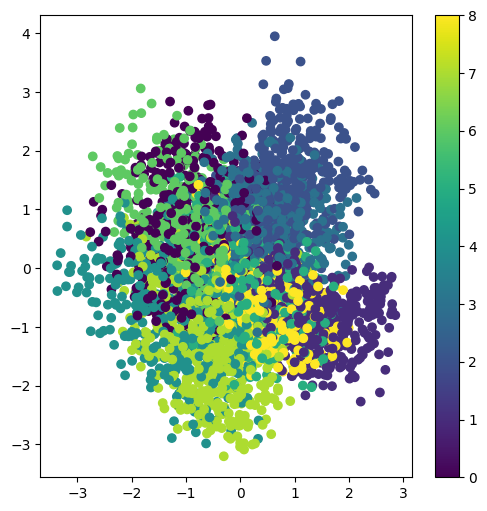

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
plt.colorbar()
plt.show()

17/17 [==============================] - 0s 13ms/step


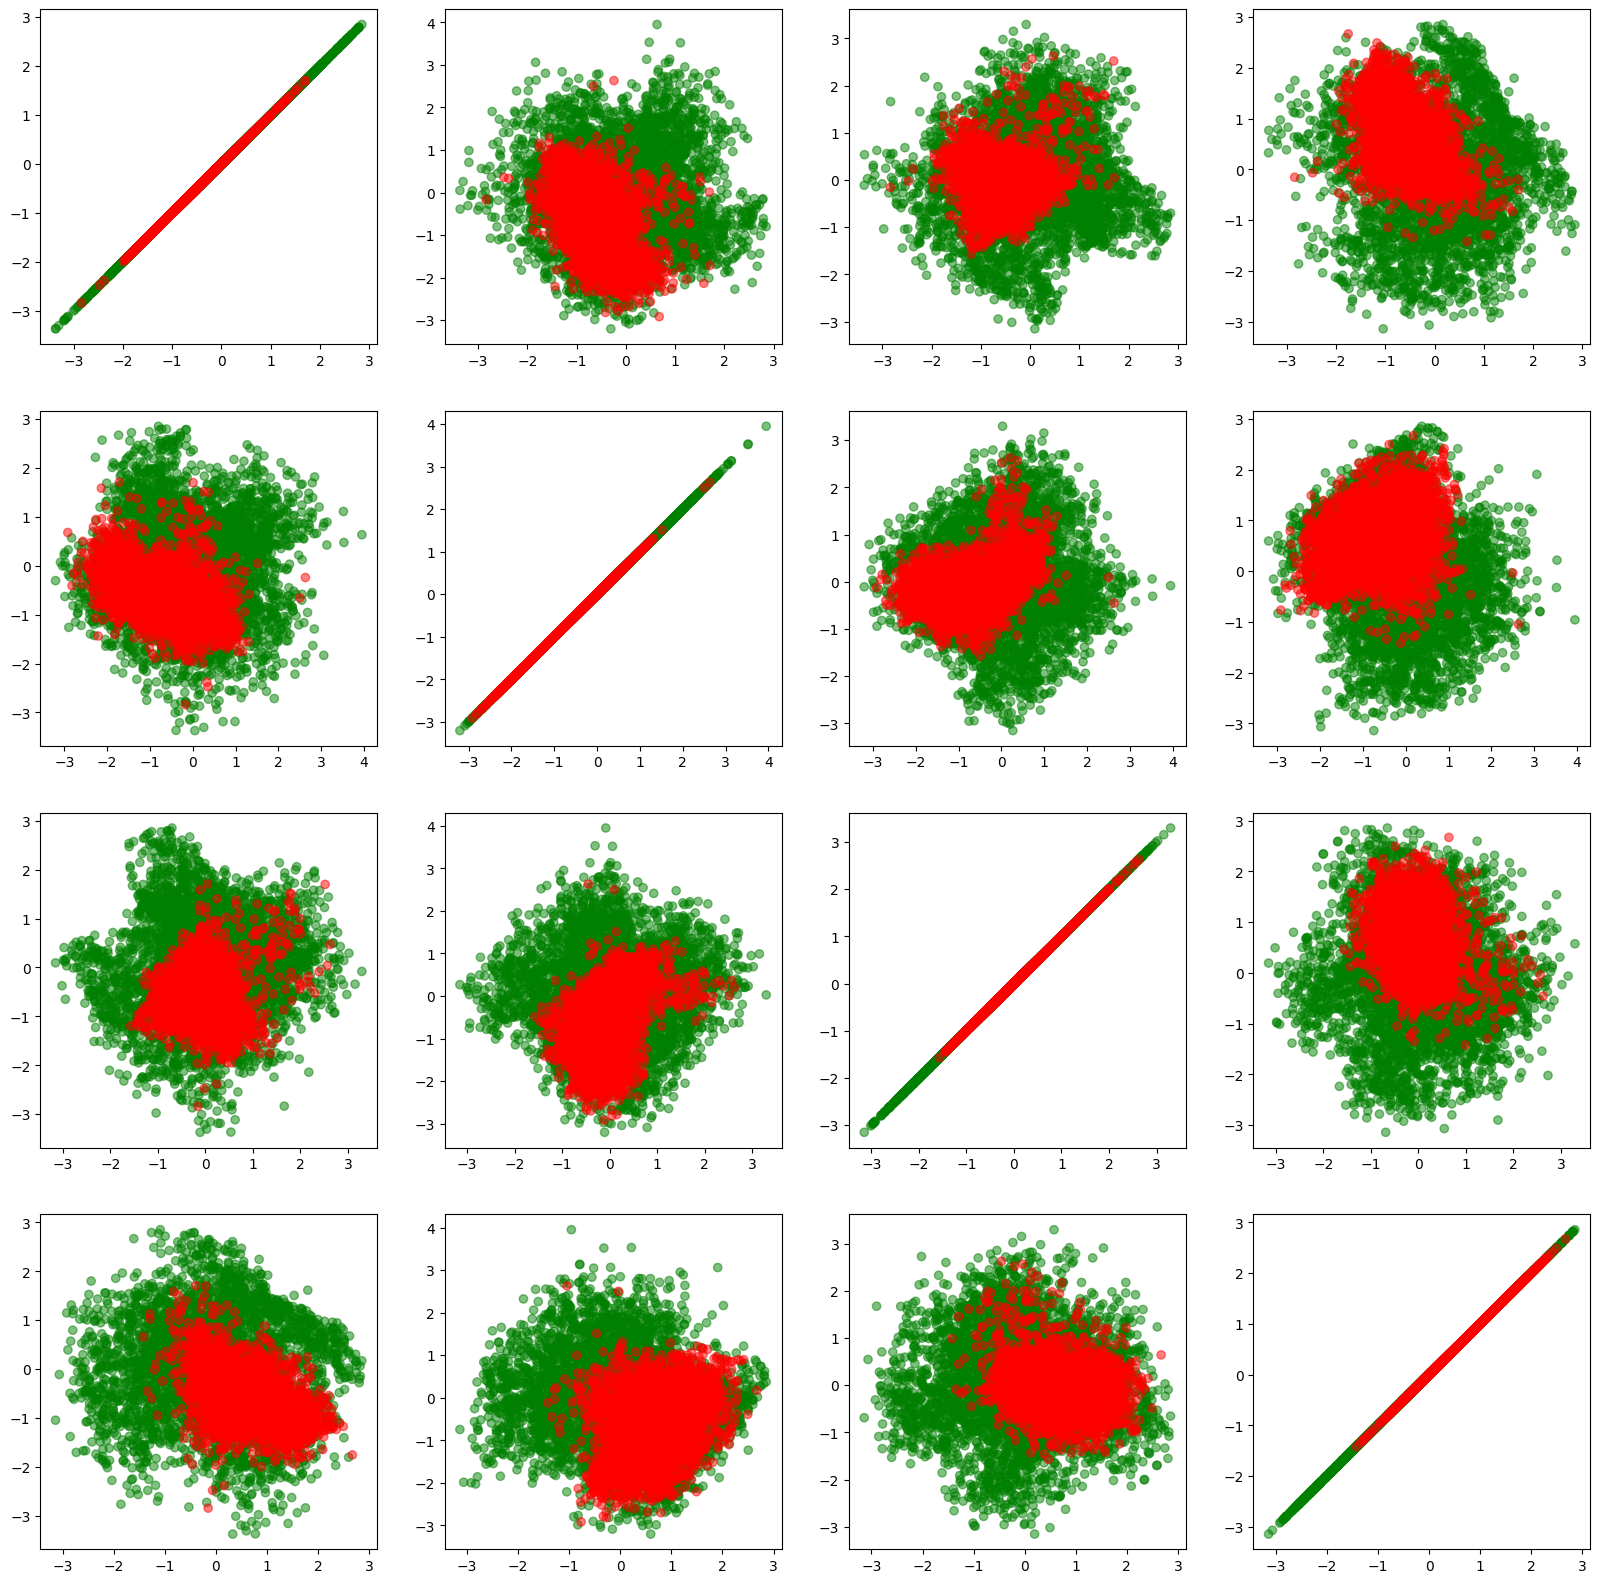

In [13]:
anomaly_encoded = encoder.predict(anomaly_test, batch_size=batch_size)
fig, m_axs = plt.subplots(latent_dim,latent_dim, figsize=(latent_dim*5, latent_dim*5))
if latent_dim == 1:
    m_axs = [[m_axs]]
for i, n_axs in enumerate(m_axs, 0):
    for j, c_ax in enumerate(n_axs, 0):
        c_ax.scatter(np.concatenate([X_test_encoded[:, i], anomaly_encoded[:,i]],0),
                           np.concatenate([X_test_encoded[:, j], anomaly_encoded[:,j]],0),
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8376 samples in 0.013s...
[t-SNE] Computed neighbors for 8376 samples in 0.948s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8376
[t-SNE] Computed conditional probabilities for sample 2000 / 8376
[t-SNE] Computed conditional probabilities for sample 3000 / 8376
[t-SNE] Computed conditional probabilities for sample 4000 / 8376
[t-SNE] Computed conditional probabilities for sample 5000 / 8376
[t-SNE] Computed conditional probabilities for sample 6000 / 8376
[t-SNE] Computed conditional probabilities for sample 7000 / 8376
[t-SNE] Computed conditional probabilities for sample 8000 / 8376
[t-SNE] Computed conditional probabilities for sample 8376 / 8376
[t-SNE] Mean sigma: 0.212297
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.189728
[t-SNE] KL divergence after 500 iterations: 1.655039


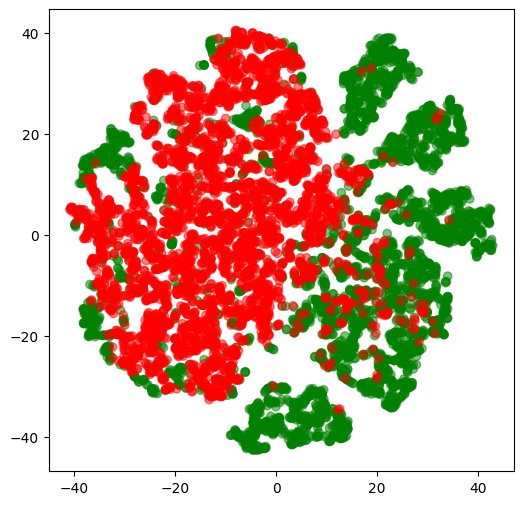

In [15]:
from sklearn.manifold import TSNE
latent_space_tsne = TSNE(2, verbose = True, n_iter = 500)
xa_tsne = latent_space_tsne.fit_transform(np.concatenate([X_test_encoded[:, :], anomaly_encoded[:,:]],0))

plt.figure(figsize=(6, 6))
plt.scatter(xa_tsne[:,0], xa_tsne[:,1],
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)
plt.show()

17/17 [==============================] - 0s 7ms/step


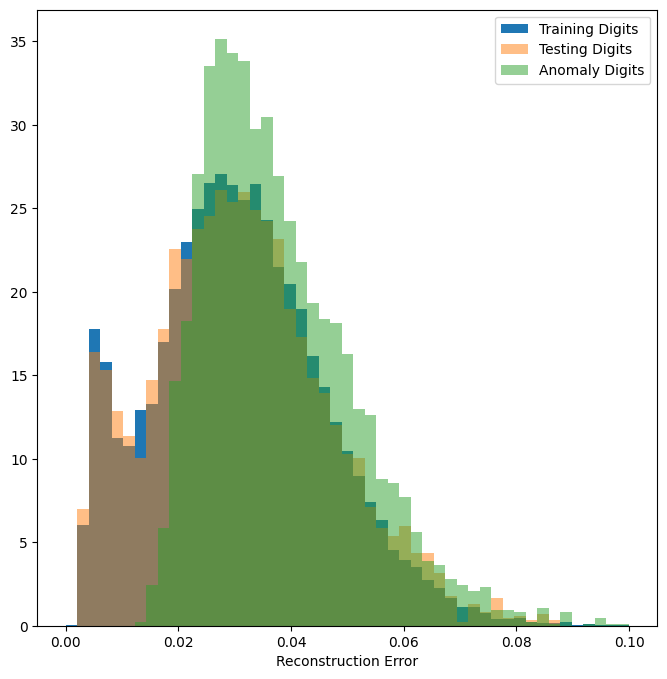

In [17]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), (1,2,3))
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, .1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(X_test), bins = np.linspace(0, .1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
ax1.hist(model_mse(anomaly_test), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

17/17 [==============================] - 0s 12ms/step


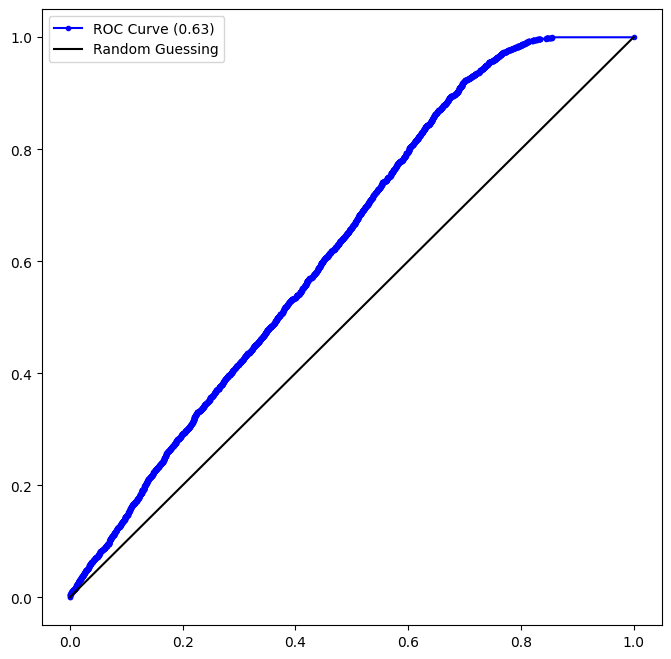

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([model_mse(X_test), model_mse(anomaly_test)],0)
true_label = [0]*X_test.shape[0]+[1]*anomaly_test.shape[0]
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

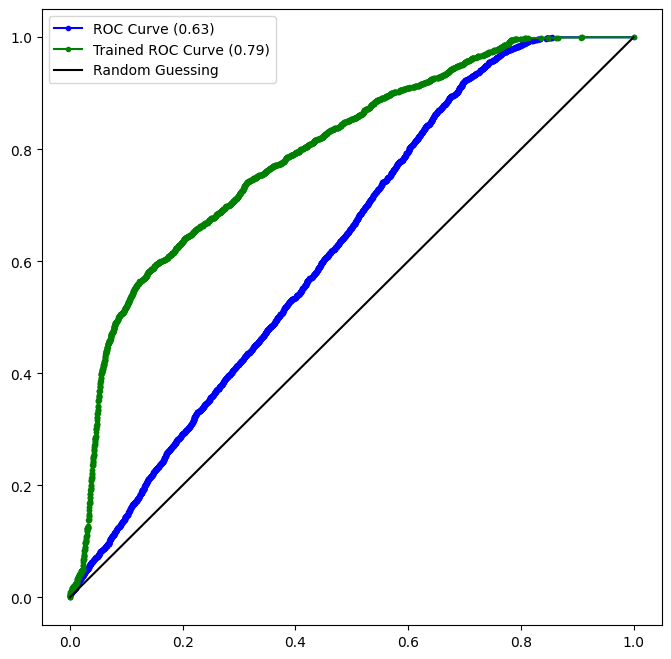

In [20]:
anom_exam = np.mean(xa_tsne[-5:,:],0)
mse_score_train = np.sqrt(np.square(xa_tsne[:,0]-anom_exam[0])+np.square(xa_tsne[:,1]-anom_exam[1]))
if roc_auc_score(true_label, mse_score_train)<0.5:
    mse_score_train *= -1

fpr_new, tpr_new, thresholds = roc_curve(true_label, mse_score_train)
auc_score_new = roc_auc_score(true_label, mse_score_train)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr_new, tpr_new, 'g.-', label = 'Trained ROC Curve (%2.2f)' %  auc_score_new)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

1/1 [==============================] - 0s 22ms/step


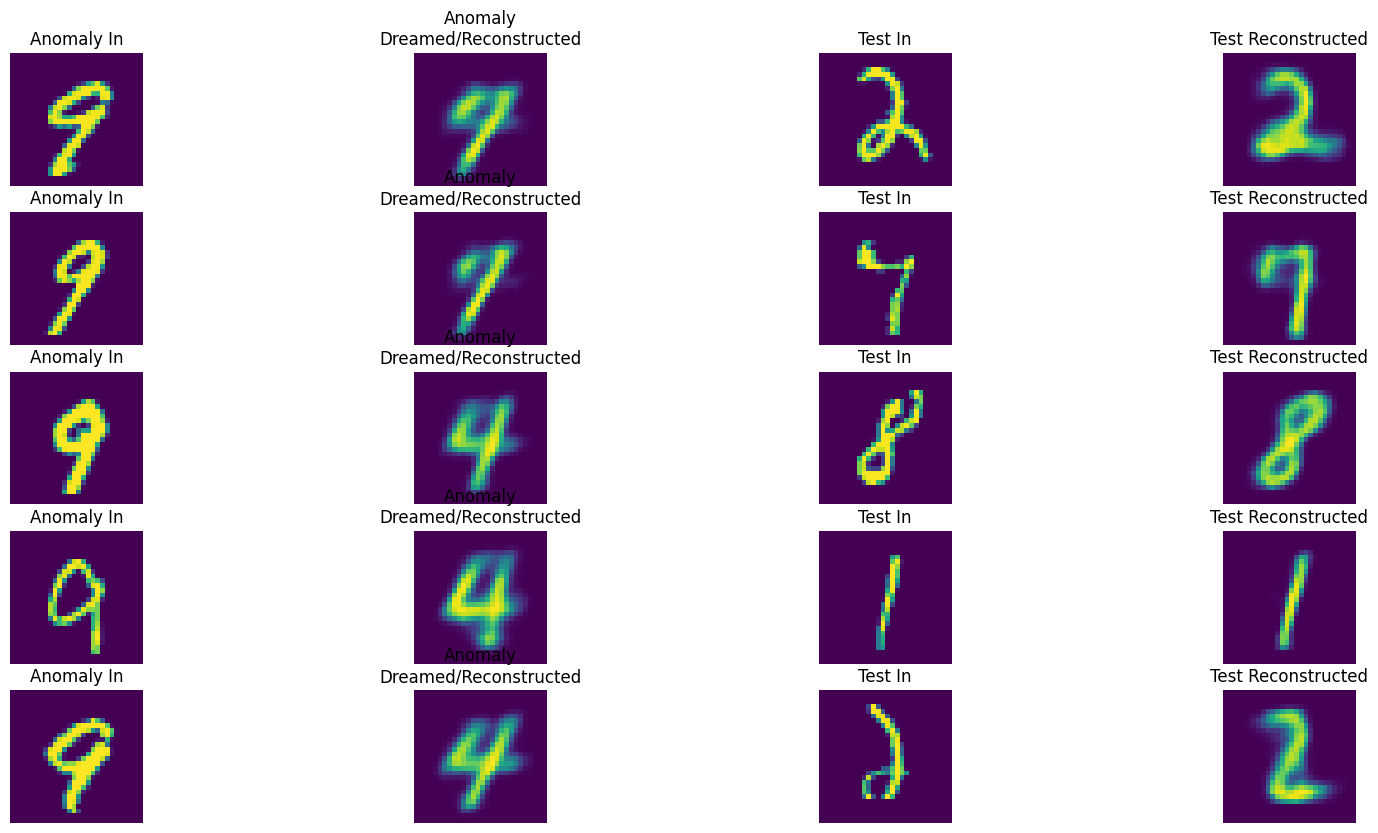

In [21]:
fig, m_axs = plt.subplots(5,4, figsize=(20, 10))
[c_ax.axis('off') for c_ax in m_axs.ravel()]
for i, (axa_in, axa_vae, axt_in, axt_vae) in enumerate(m_axs):
    axa_in.imshow(anomaly_test[i,:,:,0])
    axa_in.set_title('Anomaly In')
    axa_vae.imshow(vae.predict(anomaly_test[i:i+1])[0,:,:,0])
    axa_vae.set_title('Anomaly\nDreamed/Reconstructed')
    axt_in.imshow(X_test[i,:,:,0])
    axt_in.set_title('Test In')
    axt_vae.imshow(vae.predict(X_test[i:i+1])[0,:,:,0])
    axt_vae.set_title('Test Reconstructed')